In [131]:
import umap
import torch

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from pedalboard.pedalboard import load_plugin
from sklearn.preprocessing import LabelEncoder

from src.dataset.audio_dataset import AudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.utils import audio_to_mel_spectrogram

from src.models.vqvae.mel_spec_vqvae import MelSpecVQVAE

sns.set(style='white', context='poster')

In [132]:
DAFX_TO_USE = [
    'mda MultiBand',
    # 'clean',
    'mda Delay',
    'mda Overdrive',
    # 'mda Ambience',
    'mda RingMod',
    # 'mda Leslie',
    # 'mda Combo',
    'mda Thru-Zero Flanger',
    # 'mda Loudness',
    # 'mda Limiter',
    # 'mda Dynamics',
]

In [133]:
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_MelSpecVQVAE/q4f53chf/checkpoints/epoch=27-step=8764.ckpt"
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES = 100
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [134]:
model = MelSpecVQVAE.load_from_checkpoint(CHECKPOINT).to(DEVICE)
model.eval()

MelSpecVQVAE(
  (_encoder): Encoder(
    (_conv_1): Conv2d(1, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(2, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(2, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (1): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(2, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (2): Residual

In [135]:
proj = umap.UMAP().fit_transform(model._vq_vae._embedding.weight.data.cpu())

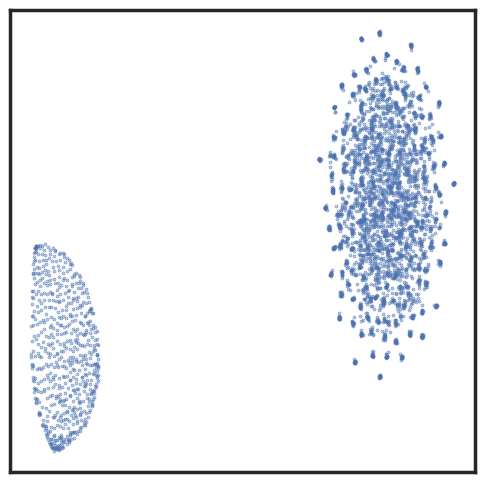

In [143]:
fig, ax = plt.subplots(1, figsize=(6,6))

ax.scatter(proj[:,0], proj[:,1], alpha=0.7, s=0.4)

ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [116]:
def dafx_from_name(dafx_name):
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [117]:
def get_dataset(dafx):
    dataset = AudioDataset(
        dafx=dafx,
        audio_dir=AUDIO_DIR,
        subset="train",
        input_dirs=DATASETS,
        num_examples_per_epoch=NUM_EXAMPLES,
        augmentations={},
        length=130_560,
        effect_audio=True,
        dummy_setting=True
    )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

In [118]:
# latent_embeddings = dict()

In [120]:
codebook = model._vq_vae._embedding.weight.data.cpu()

In [121]:
# reducer = umap.UMAP()

In [122]:
# codebook_proj = reducer.fit_transform(codebook)

In [123]:
dafx = dafx_from_name(DAFX_TO_USE[-1])
dataset = get_dataset(dafx)

x = next(iter(dataset))

100%|██████████████████████████████████████████| 88/88 [00:00<00:00, 435.03it/s]


Loaded 88 files for train = 66.89 hours.


In [124]:
X = audio_to_mel_spectrogram(signal=x,
                                     sample_rate=model.hparams.sample_rate,
                                     n_mels=model.hparams.n_mels,
                                     n_fft=model.hparams.n_fft,
                                     win_length=model.hparams.win_length,
                                     f_max=model.hparams.f_max,
                                     f_min=model.hparams.f_min).to(DEVICE)

In [125]:
z = model._encoder(X)
inputs = model._pre_vq_conv(z)
loss, quantized, perplexity, enc = model._vq_vae(z)

In [126]:
inputs.shape

torch.Size([1, 4, 64, 64])

In [37]:
# from tqdm import tqdm
#
# embeddings = []
#
# for fx in DAFX_TO_USE:
#     dafx = dafx_from_name(fx)
#     dataset = get_dataset(dafx)
#
#     for x in tqdm(dataset):
#         X = audio_to_mel_spectrogram(signal=x,
#                                      sample_rate=model.hparams.sample_rate,
#                                      n_mels=model.hparams.n_mels,
#                                      n_fft=model.hparams.n_fft,
#                                      win_length=model.hparams.win_length,
#                                      f_max=model.hparams.f_max,
#                                      f_min=model.hparams.f_min).to(DEVICE)
#
#         z = model._encoder(X)
#         z = model._pre_vq_conv(z)
#         loss, quantized, perplexity, enc = model._vq_vae(z)
#
#         q = quantized.cpu().detach().numpy()
#
#         print(quantized.shape)
#         print(torch.sum(enc == 1))
#
#         print("Embedding in codebook: ", any(np.equal(codebook, q).all(1)))
#
#         embeddings.append(q)

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 47866.52it/s]



Loaded 88 files for train = 66.89 hours.


  0%|          | 0/100 [00:00<?, ?it/s]/home/kieran/Level5ProjectAudioVAE/venv/lib/python3.10/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (2049) may be set too low.
  warnings.warn(
  0%|          | 0/100 [00:02<?, ?it/s]

torch.Size([1, 128, 64, 64])
tensor(4096, device='cuda:0')


ValueError: operands could not be broadcast together with shapes (4096,128) (1,128,64,64) 

In [10]:
# model._vq_vae._embedding.weight.data.cpu().shape

torch.Size([4096, 128])

torch.Size([4096, 128])

In [11]:
# proj = umap.UMAP().fit_transform(model._vq_vae._embedding.weight.data.cpu())

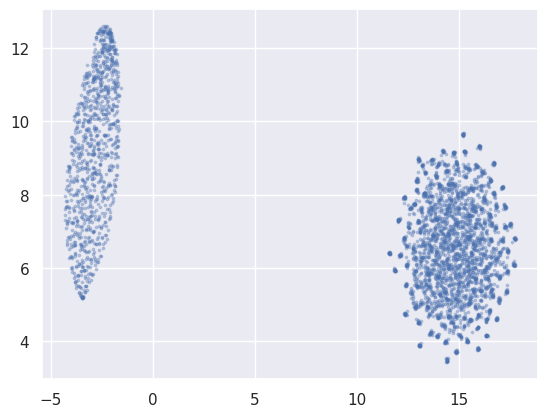

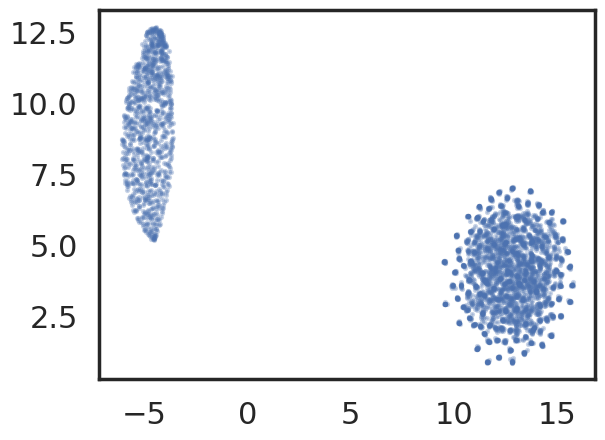

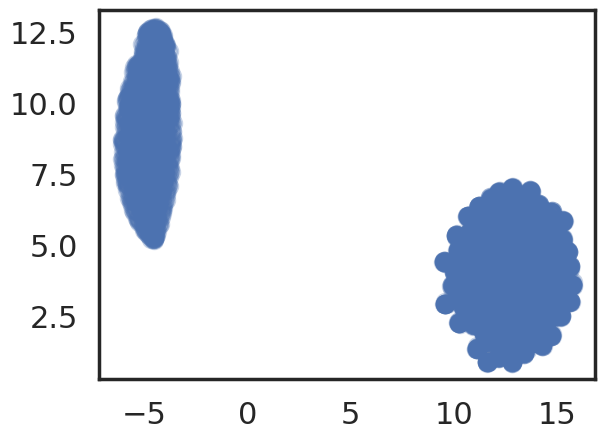

In [13]:
# plt.scatter(proj[:,0], proj[:,1], alpha=0.3)
# plt.show()